In [1]:
library(tidyverse)
library(repr)
library(caret)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



After installing tidyverse, repr, and caret, we needed to first load our datasets in via the git clone command in our terminal of juptyer:

git clone https://github.com/UBC-DSCI/datasets.git

In [2]:
install.packages('e1071')
library(e1071)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


We are planning on using read_csv() to take in the dataset once it is cloned into our Jupyter hub. Let's first take a look at the dataset:

In [3]:
kidney_rough <- read_csv('datasets/chronic_kidney_disease/chronic_kidney_disease_full.csv')
glimpse(kidney_rough)

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_integer(),
  bp = col_integer(),
  sg = col_double(),
  al = col_integer(),
  su = col_integer(),
  bgr = col_integer(),
  bu = col_double(),
  sc = col_double(),
  sod = col_double(),
  pot = col_double(),
  hemo = col_double(),
  pcv = col_integer(),
  wbcc = col_double(),
  rbcc = col_double()
)
See spec(...) for full column specifications.


Observations: 400
Variables: 25
$ age   <int> 48, 7, 62, 48, 51, 60, 68, 24, 52, 53, 50, 63, 68, 68, 68, 40...
$ bp    <int> 80, 50, 80, 70, 80, 90, 70, NA, 100, 90, 60, 70, 70, 70, 80, ...
$ sg    <dbl> 1.020, 1.020, 1.010, 1.005, 1.010, 1.015, 1.010, 1.015, 1.015...
$ al    <int> 1, 4, 2, 4, 2, 3, 0, 2, 3, 2, 2, 3, 3, NA, 3, 3, 2, NA, 0, 1,...
$ su    <int> 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 4, 0, 1, NA, 2, 0, 0, NA, 3, 0,...
$ rbc   <chr> NA, NA, "normal", "normal", "normal", NA, NA, "normal", "norm...
$ pc    <chr> "normal", "normal", "normal", "abnormal", "normal", NA, "norm...
$ pcc   <chr> "notpresent", "notpresent", "notpresent", "present", "notpres...
$ ba    <chr> "notpresent", "notpresent", "notpresent", "notpresent", "notp...
$ bgr   <int> 121, NA, 423, 117, 106, 74, 100, 410, 138, 70, 490, 380, 208,...
$ bu    <dbl> 36, 18, 53, 56, 26, 25, 54, 31, 60, 107, 55, 60, 72, 86, 90, ...
$ sc    <dbl> 1.2, 0.8, 1.8, 3.8, 1.4, 1.1, 24.0, 1.1, 1.9, 7.2, 4.0, 2.7, ...
$ sod   <dbl> NA, NA

### Description:

Chronic kidney disease (CKD) is the presence of kidney damage, or a decreased level of kidney function, for three months or more (The Kidney Foundation of Canada). To accurately diagnose CKD, a wide variety of blood and urine tests can be performed, and risk factors such as age, diabetes, and coronary heart disease can be useful for determining the progression of disease (Mayo Clinic). **Our goal in this research project is to determine of the data variables collected on CKD and non-CKD patients, which variable is the most important in categorizing a CKD vs. non-CKD patient.** Chronic Kidney Disease Data Set was collected from Apollo Hospital for a two months ending in July 2015. There are 25 attributes where 11 are numerical variables, and 14 are characteristic variables. (UCI Machine Learning Repository)

### Problems:
1) We have NA values in our class column, these are rows that are not useful to us when we are attempting to train our classifier. We need to remove these first before beginning our analysis

2) In our wbcc column, we need to convert values that are in scientific notation (10e3) to a more readable form (integer). 

3) We have 11 numerical variables and 14 characteristic variables. Our statistical analysis will only use the numerical variables. As such, we need to separate our data into numerical and characteristic variables. It's possible that we still use the characteristic variables in the training of our dataset downstream.

4) Various format changes: we need to scale our data so that our distance calculations are not weighted towards any specific column, we need to convert our class variable to a factor type, and we need to create an NA free data set for our ggpair() analysis

In [4]:
#Our first step is to read our data through the read_csv() function, and 

kidney <- read_csv('datasets/chronic_kidney_disease/chronic_kidney_disease_full.csv') %>% 
    mutate(class = as.factor(class)) %>%
    #Removed NA values in our class column only
    filter(!is.na(class)) %>%
    mutate(wbcc = as.integer(wbcc))  #changed all scientific notation to integer

kidney_num <- kidney %>% #Select all of the columns that are numerical data, we will also include a categorical variable for comparison
    select(-sg, -su, -rbc, -pc, -pcc, -ba, -htn, -dm, -cad, -appet, -pe, -ane)

kidney_scaled <- kidney_num %>% #We need to now scale the data
    select(-c(age, class)) %>% #Remove the columns that are not numerical data, but contain 
    scale(center = FALSE)

kidney_scaled <- data.frame(age = kidney$age, kidney_scaled, class = kidney$class)

kidney_nona <- kidney_scaled %>% drop_na()

#is.factor(kidney$class)

head(kidney_scaled)


Parsed with column specification:
cols(
  .default = col_character(),
  age = col_integer(),
  bp = col_integer(),
  sg = col_double(),
  al = col_integer(),
  su = col_integer(),
  bgr = col_integer(),
  bu = col_double(),
  sc = col_double(),
  sod = col_double(),
  pot = col_double(),
  hemo = col_double(),
  pcv = col_integer(),
  wbcc = col_double(),
  rbcc = col_double()
)
See spec(...) for full column specifications.


age,bp,al,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,class
48,1.0278113,0.5900968,0.7191124,0.4692584,0.1835944,NA,NA,1.1952734,1.1008365,0.8735420,1.0759119,ckd
7,0.6423821,2.3603874,NA,0.2346292,0.1223963,NA,NA,0.8770512,0.9507225,0.6719554,NA,ckd
62,1.0278113,1.1801937,2.5139220,0.6908526,0.2753916,NA,NA,0.7451055,0.7755894,0.8399443,NA,ckd
48,0.8993349,2.3603874,0.6953401,0.7299575,0.5813823,0.8035411,0.4432017,0.8692897,0.8006084,0.7503502,0.8069339,ckd
51,1.0278113,1.1801937,0.6299663,0.3389088,0.2141935,NA,NA,0.9003358,0.8756654,0.8175458,0.9517682,ckd
60,1.1562878,1.7702905,0.4397878,0.3258739,0.1682949,1.0279535,0.5672982,0.9469049,0.9757415,0.8735420,0.9103870,ckd


In [5]:
head(kidney)

age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,⋯,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
48,80,1.020,1,0,NA,normal,notpresent,notpresent,121,⋯,44,7800,5.2,yes,yes,no,good,no,no,ckd
7,50,1.020,4,0,NA,normal,notpresent,notpresent,NA,⋯,38,6000,NA,no,no,no,good,no,no,ckd
62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,⋯,31,7500,NA,no,yes,no,poor,no,yes,ckd
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,⋯,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,⋯,35,7300,4.6,no,no,no,good,no,no,ckd
60,90,1.015,3,0,NA,NA,notpresent,notpresent,74,⋯,39,7800,4.4,yes,yes,no,good,yes,no,ckd


Now that we have our data, it is time to provide summary statistics to explore our dataset. Our goal is to narrow our focus on four variables that we believe have an impact on CKD classification. To do this, we will calculate the mean of each numerical variable grouped on CKD classification to compare the difference between CKD and non-CKD patients. The columns that contain the top five differences in our variable group will be used downstream to build our classifiers. 

In [6]:
#  typeof(kidney_scaled$bu)


kidney_means <- kidney_scaled %>% 
    group_by(class) %>% #We are interested in the differences between ckd and non ckd patients based on all numerical characteristics
    summarize_all(mean, na.rm = TRUE) %>% #This returns a row that contains the means of all of our columns, however, 
                                          #it is easier to comcpare if these are displayed in columns.
    gather(key = 'variable', value = 'value', -class) %>% #transpose elements by gathering and respreading
    spread(class, value) %>% 
    mutate(difference = abs(ckd - notckd)) %>% #Create a column that contains the differences of our ckd and notckd columns
    arrange(desc(difference)) #arrange from highest to lowest differences.
    

kidney_means

t.test(kidney_scaled$hemo~kidney_scaled$class)
is.factor(kidney_means$age)

variable,ckd,notckd,difference
age,54.4250000,46.3243243,8.10067568
al,1.0156475,0.0000000,1.01564745
sc,0.6778795,0.1330209,0.54485858
bu,0.9470699,0.4261427,0.52092713
bgr,1.0431517,0.6402316,0.40292011
hemo,0.8267734,1.1796961,0.35292262
pcv,0.8234158,1.1593293,0.33591348
rbcc,0.8186862,1.1137961,0.29510993
wbcc,1.0197419,0.8609232,0.15881871
bp,1.0240326,0.9168147,0.10721791



	Welch Two Sample t-test

data:  kidney_scaled$hemo by kidney_scaled$class
t = -24.306, df = 333.36, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3814853 -0.3243600
sample estimates:
   mean in group ckd mean in group notckd 
           0.8267734            1.1796961 


Warning message:
“Unknown or uninitialised column: 'age'.”

[1] FALSE

We originally chose to find the differences of the means between CKD and non-CKD patients in all of our numerical variables as a means to narrow down our top predictors. However, this method does not take into effect the spread of the data, which could complicate our classifiers if we choose from this chart. Thus, we use ggpairs function to get the graphs and the correlations between the variables and our kidney disease class. 

In [7]:
install.packages('GGally')
library(GGally)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa



Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”Warning message in cor(x, y, method = method, use = use):
“the standard deviation is zero”`stat_bin(

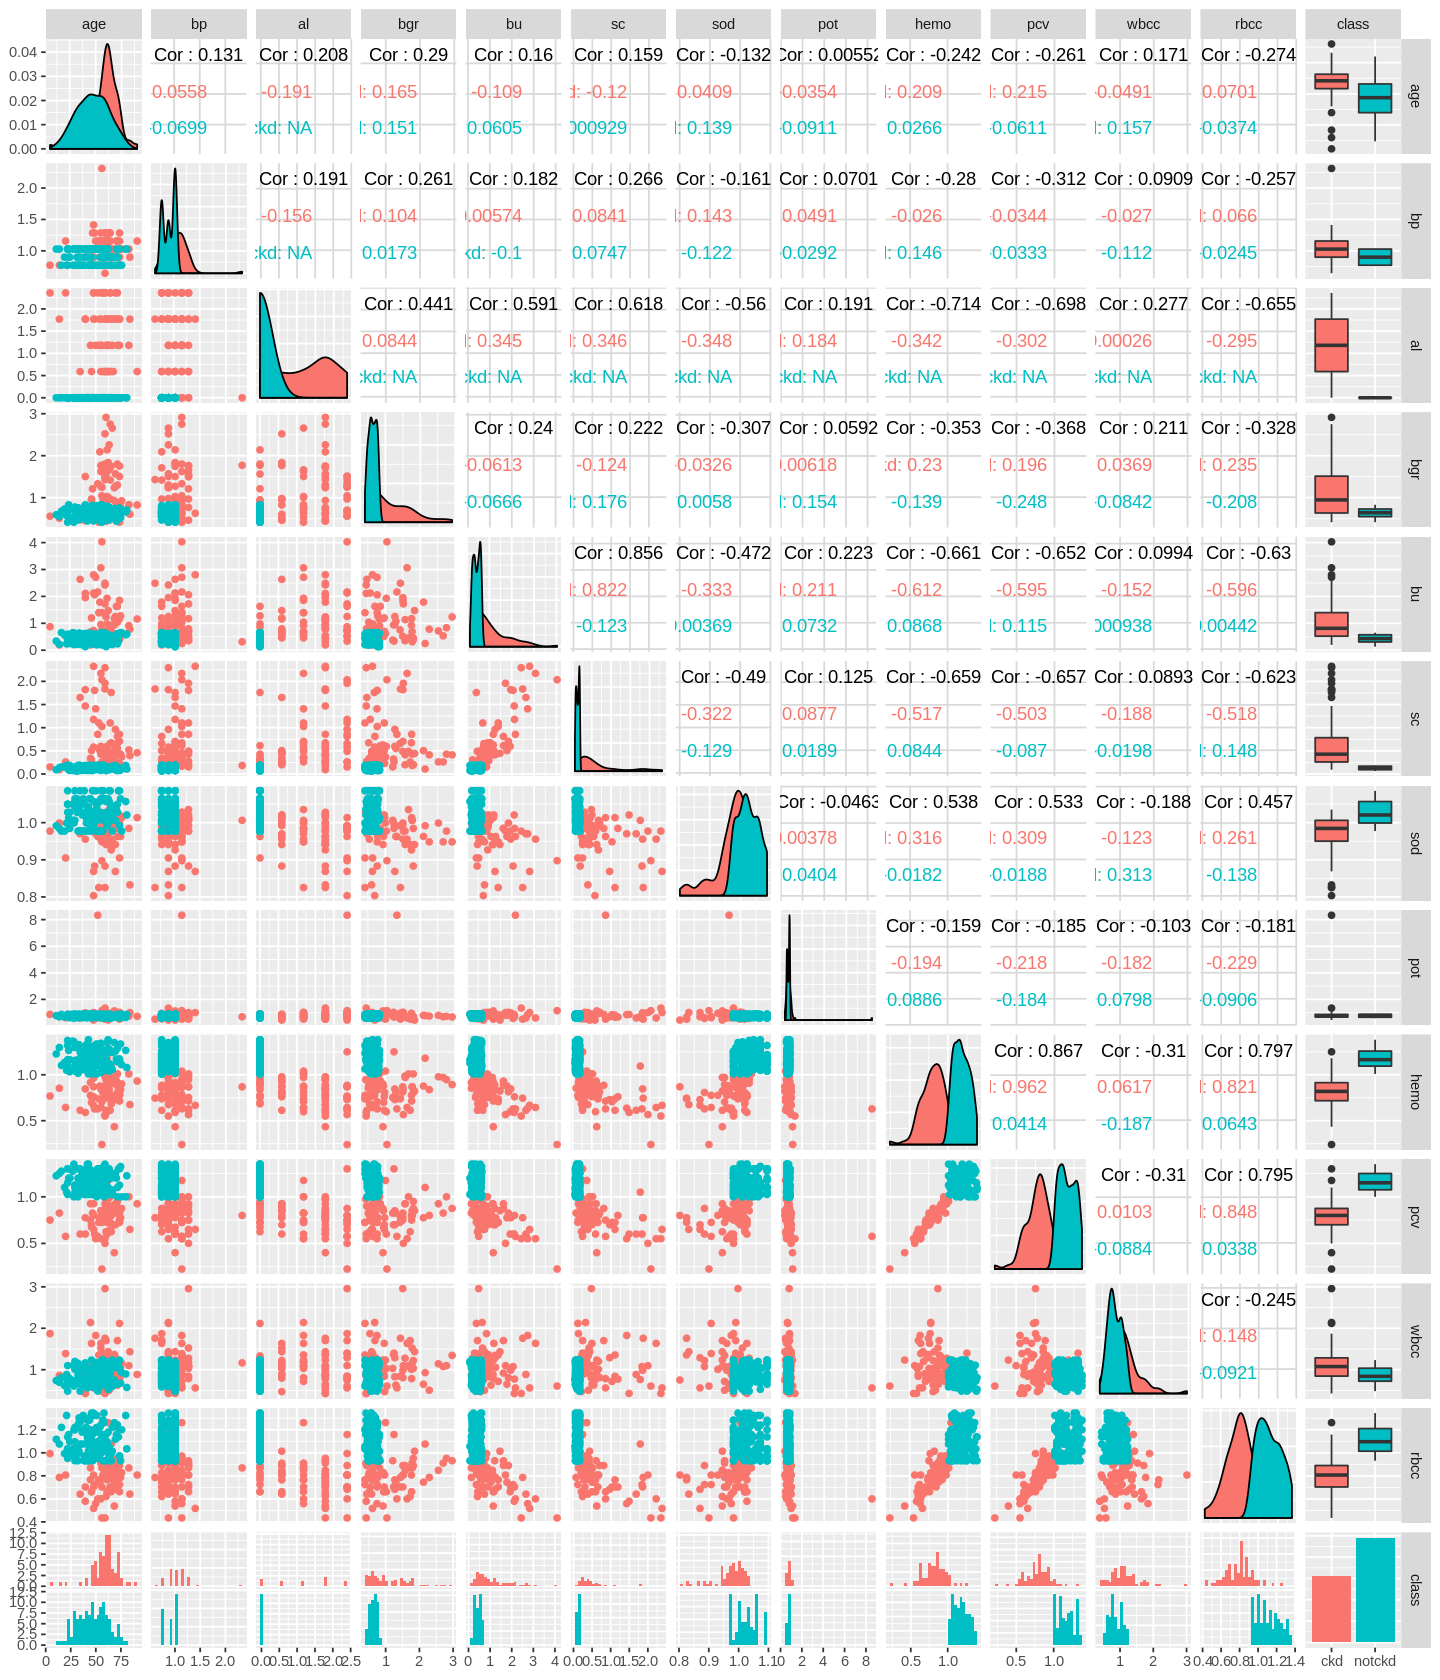

In [8]:
options(repr.plot.height = 14, repr.plot.width = 12)
kidney_total <- ggpairs(data = kidney_nona, mapping=ggplot2::aes(colour = class))
kidney_total

From the box plot we ranked the differences of the means between CKD and other variables and also considered the distribution of the data by looking at the first and the third quartiles. We compared the distributions to find which pair has the most significant difference to roughly get the top three effective variables: hemo, pcv, rbcc, sod and sc.

The three graphs below is a scale of the graphs between the vatiables we have chosen. From the graphs, we find that hemo, pcv and rbcc have obvious relationships with class, but sod and sc may not have strong relationship with class as we expected.

Warning message:
“Removed 73 rows containing missing values (geom_point).”

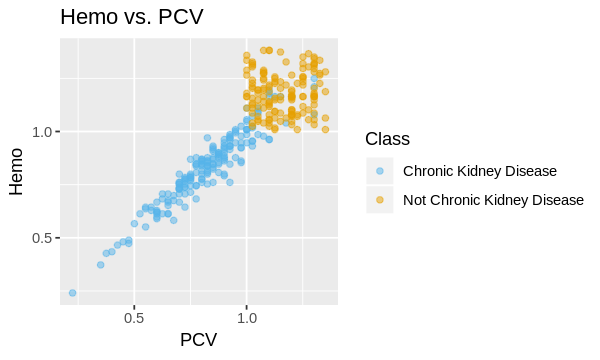

In [9]:
#hemo, pcv, rbcc, sod, sc

cbPalette <- c("#56B4E9", "#E69F00","#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999")

options(repr.plot.height = 3, repr.plot.width = 5)

pcv_homo_plot <- kidney_scaled %>% 
    ggplot(aes(x = pcv, y = hemo, colour = class)) +
    geom_point(alpha = 0.5) +
    scale_color_manual(name = "Class", labels = c("Chronic Kidney Disease", "Not Chronic Kidney Disease"), values = cbPalette) +
    xlab("PCV")+
    ylab("Hemo") +
    ggtitle("Hemo vs. PCV")

pcv_homo_plot

Warning message:
“Removed 135 rows containing missing values (geom_point).”

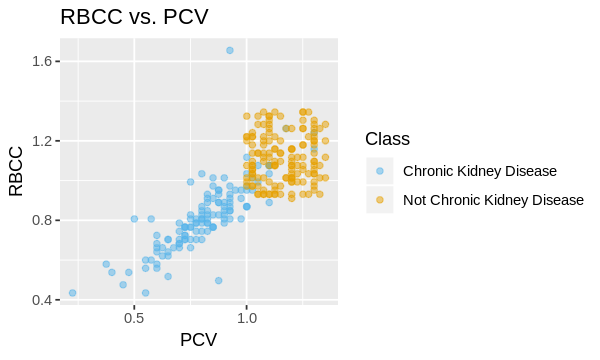

In [10]:
pcv_rbcc_plot <- kidney_scaled %>% 
    ggplot(aes(x = pcv, y = rbcc, colour = class)) +
    geom_point(alpha = 0.5) +
    scale_color_manual(name = "Class", labels = c("Chronic Kidney Disease", "Not Chronic Kidney Disease"), values = cbPalette) +
    xlab("PCV")+
    ylab("RBCC") +
    ggtitle("RBCC vs. PCV")

pcv_rbcc_plot

Warning message:
“Removed 90 rows containing missing values (geom_point).”

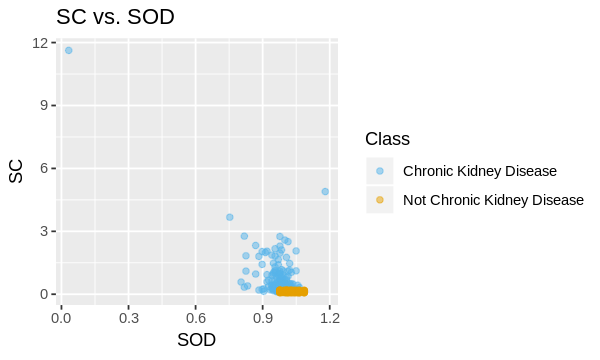

In [11]:
sod_sc_plot <- kidney_scaled %>% 
    ggplot(aes(x = sod, y = sc, colour = class)) +
    geom_point(alpha = 0.5) +
    scale_color_manual(name = "Class", labels = c("Chronic Kidney Disease", "Not Chronic Kidney Disease"), values = cbPalette) +
    xlab("SOD")+
    ylab("SC") +
    ggtitle("SC vs. SOD")

sod_sc_plot

We chose the nominal variable ‘albumin’ to use in a classifier as a negative control for numerical variables. From the ggPairs data visualization, we also chose to continue with hemoglobin (hemo), packed cell volume (pcv), and rbcc (red blood cell count (rbcc) in our downstream classification. We also decided to continue with the nominal and numerical variables that shows our top differences in means; Albumin (al) and sc (serum creatine) respectively. Finally, we chose sodium (sod) as a negative control, since it was the variable that had the least difference in means in kidney class.

The following cell contains the code for selecting the training rows that will be used to train the classifiers and validation rows against which the classifiers will be tested. 

In [12]:
set.seed(1234)

set_rows <- kidney_scaled %>% 
    select(class) %>% 
    unlist() %>% 
    createDataPartition(p = 0.75, list = FALSE) #CHECK TO SEE IF THIS IS RANDOMIZED

#head(set_rows)

training_kidney <- kidney_scaled %>% slice(set_rows)
validation_kidney <- kidney_scaled %>% slice(-set_rows)

tail(validation_kidney)
head(training_kidney)

,age,bp,al,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,class
94,30,1.0278113,0,0.4873324,0.5474681,0.1070967,1.056910,0.8864035,1.156466,1.125856,1.0527302,1.2207462,notckd
95,79,1.0278113,0,0.6596817,0.5735380,0.1835944,1.056910,0.6382105,1.265127,1.000760,0.8959406,1.3241993,notckd
96,64,0.8993349,0,0.5764786,0.3519438,0.1070967,1.049671,0.8509473,1.071089,1.225932,0.7167525,0.9931494,notckd
97,48,1.0278113,0,0.4457309,0.2867690,0.1223963,0.991758,0.8864035,1.303935,1.275970,0.6719554,1.3448899,notckd
98,41,1.0278113,0,0.6656247,0.6256778,0.1070967,1.013475,0.8864035,1.319458,1.300989,0.8063465,1.2000556,notckd
99,57,1.0278113,0,0.7904294,0.6256778,0.1835944,1.064149,0.7623070,1.148704,1.150875,0.7391510,1.1379837,notckd


age,bp,al,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,class
7,0.6423821,2.360387,NA,0.2346292,0.1223963,NA,NA,0.8770512,0.9507225,0.6719554,NA,ckd
62,1.0278113,1.180194,2.5139220,0.6908526,0.2753916,NA,NA,0.7451055,0.7755894,0.8399443,NA,ckd
51,1.0278113,1.180194,0.6299663,0.3389088,0.2141935,NA,NA,0.9003358,0.8756654,0.8175458,0.9517682,ckd
60,1.1562878,1.770291,0.4397878,0.3258739,0.1682949,1.027954,0.5672982,0.9469049,0.9757415,0.8735420,0.9103870,ckd
24,NA,1.180194,2.4366620,0.4040836,0.1682949,NA,NA,0.9624279,1.1008365,0.7727487,1.0345307,ckd
52,1.2847642,1.770291,0.8201448,0.7820973,0.2906911,NA,NA,0.8382437,0.8256274,1.0751287,0.8276245,ckd


The cell below contains the code for the training and validation sets for the Hemo variable. Note that the na.omit() is added after the selection of the columns to preserve the columns that have values for the intended variable and the class but miss values for other variables.

In [13]:
set.seed(1234)

ks = data.frame(k = seq(1, 49))

training_hemo_nona <- training_kidney %>%
    select(hemo, class) %>% 
    na.omit()

training_hemo_X <- training_hemo_nona %>% 
    select(hemo) %>%
    data.frame()

training_hemo_Y <- training_hemo_nona %>% 
    select(class) %>% 
    unlist()

val_hemo <-  validation_kidney %>% 
    select(hemo, class) %>% 
    na.omit()

val_hemo_X <- val_hemo %>% 
    select(hemo) %>% 
    data.frame()

val_hemo_Y <- val_hemo %>% 
    select(class) %>% 
    unlist()

train_control <- trainControl(method = 'cv', number = 3)

hemo_train <- train(x = training_hemo_X, y = training_hemo_Y, method = 'knn', tuneGrid = ks, trControl = train_control)
# hemo_train

k <- data.frame(k = 9)

hemo_final <- train(x = training_hemo_X, y = training_hemo_Y, method = 'knn', tuneGrid = k)
# hemo_final

The following cell contains the code for the RBCC variable classifier. Note that the same strategy for removing missing values is used.

In [14]:
set.seed(1234)

ks = data.frame(k = seq(1, 49))

training_rm_na <- training_kidney %>%
    select(rbcc, class) %>%
    na.omit()%>%
    data.frame()

X_rbcc <- training_rm_na %>%
    select(rbcc)%>%
    data.frame()
Y_rbcc <- training_rm_na %>%
    select(class)%>%
    unlist()

val_rbcc <- validation_kidney %>%
    select(rbcc, class)%>%
    na.omit()%>%
    data.frame()

X_val_rbcc <- val_rbcc %>%
    select(rbcc)%>%
    data.frame()

Y_val_rbcc <- val_rbcc %>%
    select(class)%>%
    unlist()

rbcc_train <- train(x = X_rbcc, y = Y_rbcc, method = "knn", tuneGrid = ks, trControl = train_control)
# rbcc_train
k <- data.frame(k = 6)

rbcc_final <- train(x = X_rbcc, y = Y_rbcc, method = "knn", tuneGrid = k)
# rbcc_final

Now the classifier using the PCV variable will be trained.

In [15]:
set.seed(1234)
#pcv sod, sc
ks = data.frame(k = seq(1, 49))


val_pcv <- validation_kidney %>% 
    select(pcv, class) %>% 
    na.omit()

val_pcv_X <- val_pcv %>% 
    select(pcv) %>% 
    na.omit()

val_pcv_Y <- val_pcv %>% 
    select(class) %>% 
    unlist()

training_pcv <- training_kidney %>% 
    select(pcv, class) %>% 
    na.omit()

training_pcv_X <- training_pcv %>%
    select(pcv) %>%
    data.frame()
training_pcv_Y <- training_pcv %>%
    select(class) %>%
    unlist()

pcv_train <- train(x = training_pcv_X, y = training_pcv_Y, method = "knn", tuneGrid = ks, trControl = train_control)
# pcv_cross
k <- data.frame(k = 45)
pcv_final <- train(x = training_pcv_X, y = training_pcv_Y, method = "knn", tuneGrid = k)
# pcv_train

The following cell will contain the code to train the SOD variable.

In [16]:
set.seed(1234)
#pcv sod, sc
ks = data.frame(k = seq(1, 49))

training_sod <- training_kidney %>% 
    select(sod, class) %>% 
    na.omit()

training_sod_X <- training_sod %>%
    select(sod) %>%
    data.frame()
training_sod_Y <- training_sod %>%
    select(class) %>%
    unlist()

val_sod <- validation_kidney %>% 
    select(sod, class) %>% 
    na.omit()

val_sod_X <- val_sod %>% 
    select(sod) %>% 
    na.omit()

val_sod_Y <- val_sod %>% 
    select(class) %>% 
    unlist()

sod_train <- train(x = training_sod_X, y = training_sod_Y, method = "knn", tuneGrid = ks, trControl = train_control)
# sod_train
k <- data.frame(k = 6)
sod_final <- train(x = training_sod_X, y = training_sod_Y, method = "knn", tuneGrid = k)
# sod_final

Lastly, a classifier using the SC variable is trained.

In [17]:
set.seed(1234)
#sc
ks = data.frame(k = seq(1, 49))

training_sc <- training_kidney %>% 
    select(sc, class) %>% 
    na.omit()

training_sc_X <- training_sc %>%
    select(sc) %>%
    data.frame()
training_sc_Y <- training_sc %>%
    select(class) %>%
    unlist()

val_sc <- validation_kidney %>% 
    select(sc, class) %>% 
    na.omit()

val_sc_X <- val_sc %>% 
    select(sc) %>% 
    na.omit()

val_sc_Y <- val_sc %>% 
    select(class) %>% 
    unlist()

sc_train <- train(x = training_sc_X, y = training_sc_Y, method = "knn", tuneGrid = ks, trControl = train_control)
# sc_train
k <- data.frame(k = 8)
sc_final <- train(x = training_sc_X, y = training_sc_Y, method = "knn", tuneGrid = k)
# sc_final

In [18]:
set.seed(1234)
#sc
ks = data.frame(k = seq(1, 49))

training_al <- training_kidney %>% 
    select(al, class) %>% 
    na.omit()

training_al_X <- training_al %>%
    select(al) %>%
    data.frame()
training_al_Y <- training_al %>%
    select(class) %>%
    unlist()

val_al <- validation_kidney %>% 
    select(al, class) %>% 
    na.omit()

val_al_X <- val_al %>% 
    select(al) %>% 
    na.omit()

val_al_Y <- val_al %>% 
    select(class) %>% 
    unlist()

al_train <- train(x = training_al_X, y = training_al_Y, method = "knn", tuneGrid = ks, trControl = train_control)
# sc_train
k <- data.frame(k = 8)
al_final <- train(x = training_al_X, y = training_al_Y, method = "knn", tuneGrid = k)
# sc_final

For choosing the correct k value for each classifier, we extracted the results of each cross validation, gathered around our k column, and plotted k vs accuracy in a joint graph. In doing so, we can also get a good idea of the relative accuracies from each variable. Each variable was assigned a k value that maximized accuracy, while keeping k as low as possible.

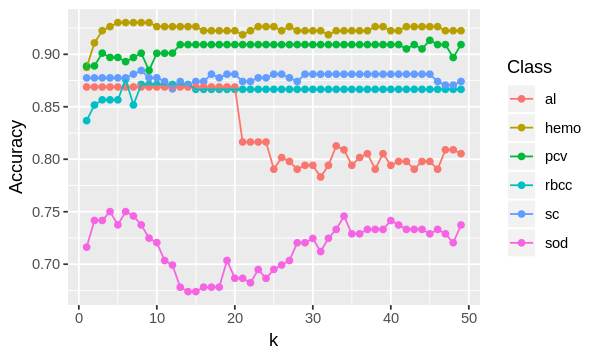

In [19]:
# graphs of K
# Results of Each train model:
hemo_cv <- hemo_train$results %>%
    select(k,Accuracy)

pcv_cv <- pcv_train$results %>%
    select(k,Accuracy)

rbcc_cv <- rbcc_train$results %>%
    select(k,Accuracy)

sc_cv <- sc_train$results %>%
    select(k,Accuracy)

sod_cv <- sod_train$results %>%
    select(k,Accuracy)

al_cv <- al_train$results %>%
    select(k,Accuracy)

k_acc <- data.frame(k = seq(1,49), 
                    hemo = hemo_cv$Accuracy, 
                    pcv = pcv_cv$Accuracy, 
                    rbcc = rbcc_cv$Accuracy, 
                    sc = sc_cv$Accuracy, 
                    sod = sod_cv$Accuracy,
                    al = al_cv$Accuracy)
k_acc <- k_acc %>%
    gather(key = Class, value = Accuracy, -k)

k_acc_plot <- k_acc %>%
    ggplot(aes(x = k, y = Accuracy, color = Class)) +
    geom_point() + 
    geom_line()

k_acc_plot

Now that all classifiers have been trained, each classifier's accuracy will be evaluated against the validation set and a measure of accuracy will be given using confusionMatrix.

In [20]:
set.seed(1234)
predictions_hemo <- predict(hemo_final, val_hemo_X)
results_hemo <- confusionMatrix(predictions_hemo, val_hemo_Y)
# results_hemo

pred_rbcc <- predict(rbcc_final, X_val_rbcc)
results_rbcc <- confusionMatrix(pred_rbcc, Y_val_rbcc)
# results_rbcc

predictions_pcv <- predict(pcv_final, val_pcv_X)
results_pcv <- confusionMatrix(predictions_pcv, val_pcv_Y)
# results_pcv

predictions_sod <- predict(sod_final, val_sod_X)
results_sod <- confusionMatrix(predictions_sod, val_sod_Y)
# results_sod

predictions_sc <- predict(sc_final, val_sc_X)
results_sc <- confusionMatrix(predictions_sc, val_sc_Y)
# results_sc

predictions_al <- predict(al_final, val_al_X)
results_al <- confusionMatrix(predictions_al, val_al_Y)

Using the results of the confusionMatrix, a bar plot of the accuracies of the variables is plotted to demonstrate their relative accuracy.

variable,accuracy
hemo,0.9431818
pcv,0.8915663
sc,0.8510638
rbcc,0.8461538
al,0.7764706
sod,0.6756757


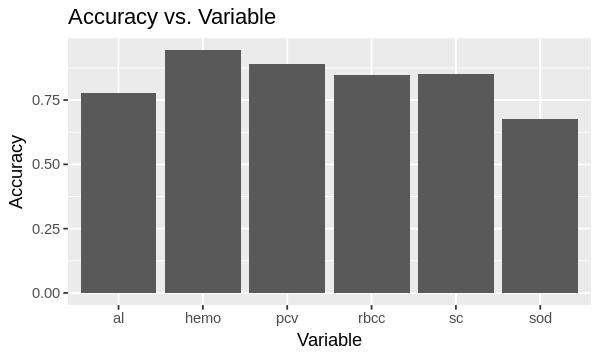

In [22]:
accuracy <- data.frame(hemo = results_hemo$overall, rbcc = results_rbcc$overall, pcv = results_pcv$overall, sod = results_sod$overall, sc = results_sc$overall, al = results_al$overall) %>% 
    head(n = 1) %>% 
    gather(key = variable, value = accuracy) %>% 
    arrange(desc(accuracy))
#     gather(key = type, value = value)
head(accuracy)

accuracy_plot <- accuracy %>% 
    ggplot(aes(x = variable, y = accuracy)) +
    geom_bar(stat = 'identity') + 
    xlab("Variable") +
    ylab("Accuracy") + 
    ggtitle("Accuracy vs. Variable")
  
accuracy_plot

As a comparison, we were interested in the potential accuracy of a classifier that uses all of our top variables (pcv, rbcc, sc, sod, hemo) to predict the class of kidney disease. We created training, and validation data sets, and performed 3-fold cross validation. After deciding that 17 was our optimal k value, we created the classifer, and tested against the validation set. The accuracy was 100% with no errors in predicting. 

Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     20      0
    notckd   0     32
                                     
               Accuracy : 1          
                 95% CI : (0.9315, 1)
    No Information Rate : 0.6154     
    P-Value [Acc > NIR] : 1.085e-11  
                                     
                  Kappa : 1          
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.3846     
         Detection Rate : 0.3846     
   Detection Prevalence : 0.3846     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : ckd        
                                     

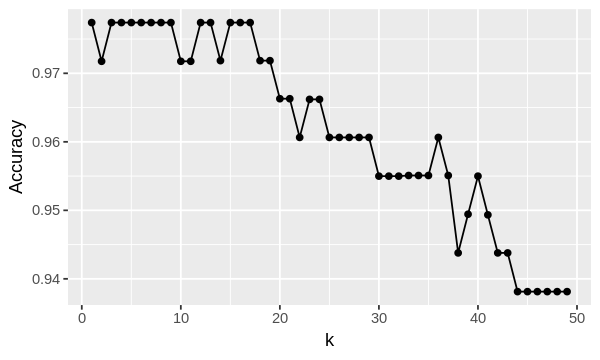

In [23]:
# multivariable classifier using the pcv, rbcc, sc, sod, hemo
set.seed(1234)
train_multi <- training_kidney %>%
    select(pcv, rbcc, sc, sod, hemo, class) %>%
    na.omit()

X_train_multi <- train_multi %>%
    select(pcv, rbcc, sc, sod, hemo) %>%
    data.frame()

Y_train_multi <- train_multi %>%
    select(class) %>%
    unlist()

val_multi <- validation_kidney %>%
    select(pcv, rbcc, sc, sod, hemo, class) %>%
    na.omit()

X_val_multi <- val_multi %>%
    select(pcv, rbcc, sc, sod, hemo) %>%
    data.frame()

Y_val_multi <- val_multi %>%
    select(class) %>%
    unlist()

train_control <- trainControl(method = "cv", number = 3)
k <- data.frame(k = seq(1, 49))
multi_train <- train(x = X_train_multi, y = Y_train_multi, method = "knn", tuneGrid = k, trControl = train_control)

multi_train_k_plot <- multi_train$results %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() + 
    geom_line()

multi_train_k_plot

k <- data.frame(k = 17)

multi_final <- train(x = X_train_multi, y = Y_train_multi, method = "knn", tuneGrid = k)

predictions_multi <- predict(multi_final, X_val_multi)
results_multi <- confusionMatrix(predictions_multi, Y_val_multi)
results_multi


# Discussion

Our top performing classifiers were our ggPair picked variables, hemo and pcv, with classifier accuracies of 94.3% and 89.1%. Next came our variable with the highest difference in mean, sc, with a classifier accuracy of 85.1%. Rbcc, al, and sod were our lowest performing classifiers with classifier accuracies of 84.6%, 77.6%, and 67.5% respectively. The initial analysis of the ggpairs plot indicated these variables to have a relatively higher correlation to the classification of non-CKD and CKD. The al variable, a categorical variable that was initially ignored, proved to have very good accuracy overall after a classifier was trained on it. The expected accuracy of these classifiers proved to be slightly lower than the actual ones that were measured using the validation sets. Hence these variables did fulfill the expected accuracy. Interestingly, our lone nominal variable (al) was surprisingly effective in classifying chronic kidney disease. We were surprised, considering that albumin can only be one of 4 values, and was initially dismissed as not being an effective variable to train a classifier. Nevertheless, albumin was more effective than sodium in classifying. Our multi-variable classifer performed the best with a 100% validation accuracy. It is unlikely that it would perform as well as 100% for larger datasets, and the high accuracy can likely be explained by the relatively small dataset.

## Impact

It is well known that characteristics such as hemoglobin, packed cell volume, and rbcc are related to anemia in patients - a hallmark of chronic kidney disease (NIDDK). Albumin and creatine levels are markers of  severe kidney failure, and are related to a hypersecretion of these proteins into the serum (kidney.org). Our findings show that certain blood markers such as hemoglobin and packed cell volume should be a higher priority of measuring from potential CKD patients as opposed to variables such as sodium levels and albumin. Ideally, the best case scenario would be to take blood tests for all 25 attributes; however, considering the sparseness of our chronic kidney disease dataset, it appears that different health care professionals prioritize different blood markers. As our world continues to become more data oriented in predicting and diagnosing disease, our findings are an attempt to prioritize and simplify which characteristics are most valuable to have in diagnosing chronic kidney disease. 

## Future Questions

Since in this project we did not choose the top five influential variables by ranking the differences of means between CKD and non-CKD patients in all of our numerical variables, we would like to know whether performing a Welch two sample T test be an effective measure of predicting whether variables are important in our classification. Doing so, and arranging the top variables in this manner is a more methodical way of choosing variables to use downstream, as opposed to selecting them by hand. In addition, we know that we can achieve 100% accuracy by training on all six variables; however, it would be still useful to know what combinations of variables are most important in classifying chronic kidney disease. Finally, it would be important to have a larger dataset for testing and validation, as we can properly see whether the classifiers that we built scale well.

### REFERENCES

1) What is kidney disease? The kidney Foundation of Canada (n.d.). Retrieved March 1, 2019, from https://www.kidney.ca/kidney-disease

2) Chronic kidney disease. (2018, March 08). Mayo Clinic. Retrieved March 1, 2019, from https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/diagnosis-treatment/drc-20354527

3) L.Jerlin Rubini  (2015). UCI Machine Learning Repository [https://archive.ics.uci.edu/ml/machine-learning-databases/00336/]. Irvine, CA: University of California, School of Information and Computer Science.

4) https://www.niddk.nih.gov/health-information/kidney-disease/anemia

5) https://www.kidney.org/kidneydisease/siemens_hcp_acr
